# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
from FORCASTphot import CombineFieldResults, remove_duplicates, createNames, findNOTindex, makeDS9reg, performApPhoto, fitshapes

In [5]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

## Combine data files for each field at 25 um

In [6]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#add names to mastercat
mastercat25=createNames(mastercat25)

#print the master catalog
mastercat25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19
10,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field49,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,1.4264758728342248,-0.020555345248797017 .. 0.0036593754586277446,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.3464-0.0829
10,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field49,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0385800764545763,0.004261958918426649 .. 0.004132877124682528,266.09495036354866,-29.53536811998432,359.34770634158383,-0.08213102280583723,2,"266.09495036354866,-29.53536811998432",SFGC359.3477-0.0821
220,235.9620459461907,68.42044737682949,"266.09854092496784,-29.536424437559138",0.14340918896069035,0.08107293401235299,0.38332149709576285,0.1614577543827247,1.2354182223561123,0.24374362747425724,842.3886568673647,0.0002534067255525879,0.0010332417175321399,0.008519584305931955,349.64801025390625,347.29145183149325,0.13006750451197777,0.6639660828530525,0.19589480226622363,52.649291054210295,0.3299547593009125,0.5450887672123689,0.6053229843431368,210.59716421684118,1.115343062317699,0.33935368996609205,3.286668438551952,473.84361948789274,Field49,25,7.121872967039468,6.509019919056004,7.972849809137938,3.7609064975077238,2.9634930492319107,39.42018067887052,1.269078899470505,11.982256156946319,10.944452578895342,0.6219383780361587,0.00011547476691359162 .. 0.019707035133246467,266.09854092496784,-29.536424437559138,359.3484408318346,-0.08534590087053735,3,"266.09854092496784,-29.536424437559138",SFGC359.3484-0.0853
220,143.54519714749512,81.44670713294987,"266.1212009924835,-29.533644793069318",-0.012934653604564906,0.08265173452530211,-0.2484

In [7]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [8]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(2.778E-4*3, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9reg('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', label="id");
makeDS9reg('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', label="aper_snr_4pix");
makeDS9reg('mastercatComb_25um_label8pixflux.reg', mastercat25, r, color='green', label="aper_sum_bkgsub_8pix");

In [9]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25=remove_duplicates(mastercat25, 5.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1024
number of likely duplicates:  383
Number of sources with duplicates removed:  813


In [10]:
#write 'master' catalogs to fits - optional for testing
#mastercat25.write('masterCat_FromFields_noDuplicates_25um.fits',overwrite=True)

In [11]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', label="id");

In [12]:
mastercat25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19,int64
10,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field49,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,1.4264758728342248,-0.020555345248797017 .. 0.0036593754586277446,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.3464-0.0829,0
10,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field49,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0385800764545763,0.004261958918426649 .. 0.004132877124682528,266.09495036354866,-29.53536811998432,359.34770634158383,-0.08213102280583723,2,"266.09495036354866,-29.53536811998432",SFGC359.3477-0.0821,0
220,235.9620459461907,68.42044737682949,"266.09854092496784,-29.536424437559138",0.14340918896069035,0.08107293401235299,0.38332149709576285,0.1614577543827247,1.2354182223561123,0.24374362747425724,842.3886568673647,0.0002534067255525879,0.0010332417175321399,0.008519584305931955,349.64801025390625,347.29145183149325,0.13006750451197777,0.6639660828530525,0.19589480226622363,52.649291054210295,0.3299547593009125,0.5450887672123689,0.6053229843431368,210.59716421684118,1.115343062317699,0.33935368996609205,3.286668438551952,473.84361948789274,Field49,25,7.121872967039468,6.509019919056004,7.972849809137938,3.7609064975077238,2.9634930492319107,39.42018067887052,1.269078899470505,11.982256156946319,10.944452578895342,0.6219383780361587,0.00011547476691359162 .. 0.019707035133246467,266.09854092496784,-29.536424437559138,359.3484408318346,-0.08534590087053735,3,"266.09854092496784,-29.536424437559138",SFGC359.3484-0.0853,0
220,143.54519714749512,81.44670713294987,"266.1212009924835,-29.533644793069318",-0.012934653604564906,0.0

### Quality flags and other cuts

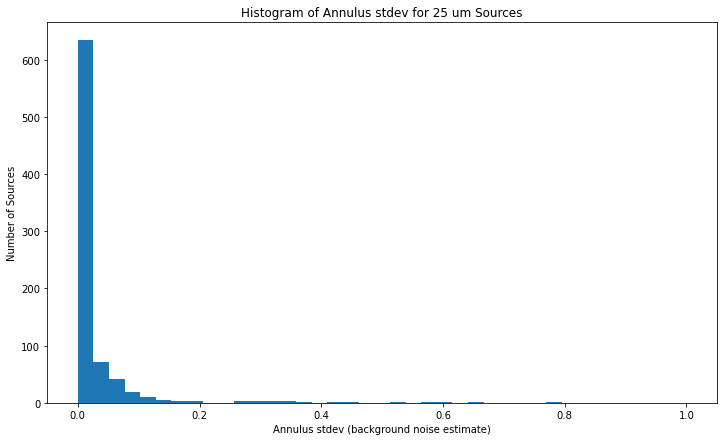

In [13]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 25 um Sources')
plt.hist(mastercat25['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [14]:
#add quality flags for background noise
bkgmean=np.mean(mastercat25['ann_bkg_std'])
bkgstd=np.std(mastercat25['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat25['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat25['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat25['ann_bkg_std']>bkgmean+3*bkgstd


mastercat25['bkg_qflag']=0
mastercat25['bkg_qflag'][bkgstd1sig]=1
mastercat25['bkg_qflag'][bkgstd2sig]=2
mastercat25['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.0358890612435692 , standard deviation of noise measurements:  0.11685252865793838


In [15]:
print('Central distance fit mean: ', np.mean(mastercat25['fit_dist']), '  stdev: ',np.std(mastercat25['fit_dist']))

Central distance fit mean:  1.4372407205097437   stdev:  1.208042457126461


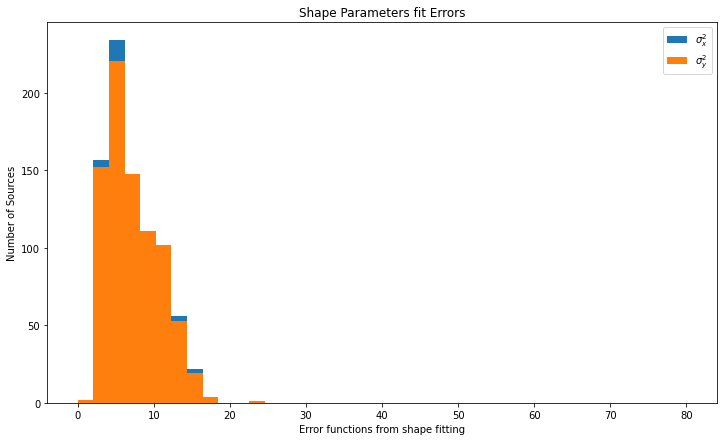

In [16]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat25['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mastercat25['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [17]:
print('Covar X^2 mean: ', np.mean(mastercat25['covar_sigx2']), '  stdev: ',np.std(mastercat25['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mastercat25['covar_sigy2']), '  stdev: ',np.std(mastercat25['covar_sigy2']))

Covar X^2 mean:  7.288642346765347   stdev:  3.417420345975252
Covar Y^2 mean:  7.324815962788298   stdev:  3.3858213339169985


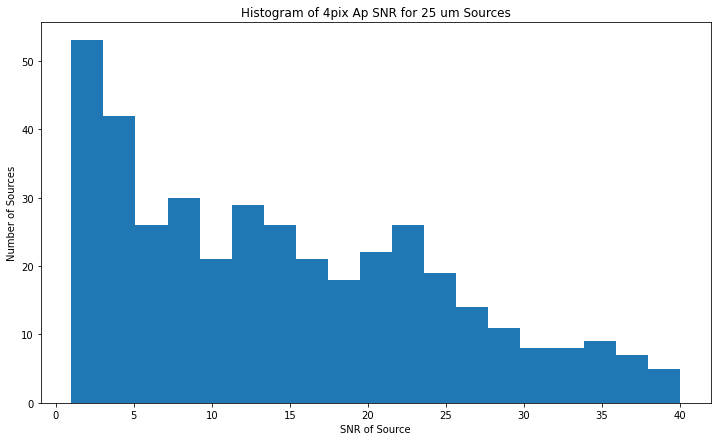

In [18]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [19]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=3.0 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  550


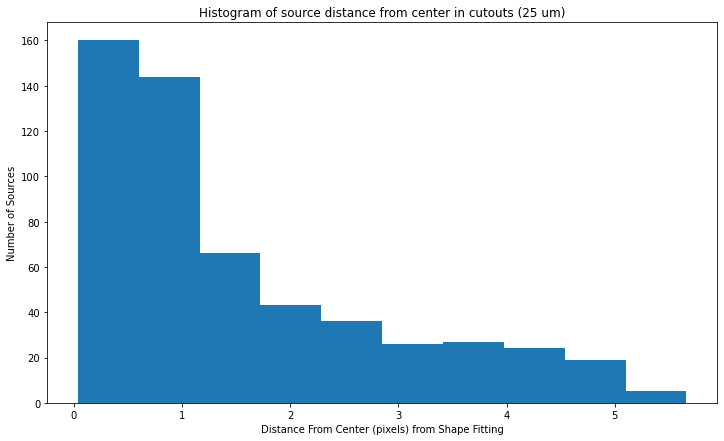

In [20]:
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (25 um)')
plt.hist(mcat25snrcut['fit_dist'])#,bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [21]:
print('Central distance fit mean: ', np.mean(mcat25snrcut['fit_dist']), '  stdev: ',np.std(mcat25snrcut['fit_dist']))

Central distance fit mean:  1.555580845491104   stdev:  1.3418153896368925


In [22]:
#apply quality flags to table
Distmean=np.mean(mcat25snrcut['fit_dist'])
Diststd=np.std(mcat25snrcut['fit_dist'])

distidx1=mcat25snrcut['fit_dist']>4.0
distidx2=mcat25snrcut['fit_dist']>7.0

mcat25snrcut['shape_qflag']=0

mcat25snrcut['shape_qflag'][distidx1]=10
mcat25snrcut['shape_qflag'][distidx2]=mcat25snrcut['shape_qflag'][distidx2]+10

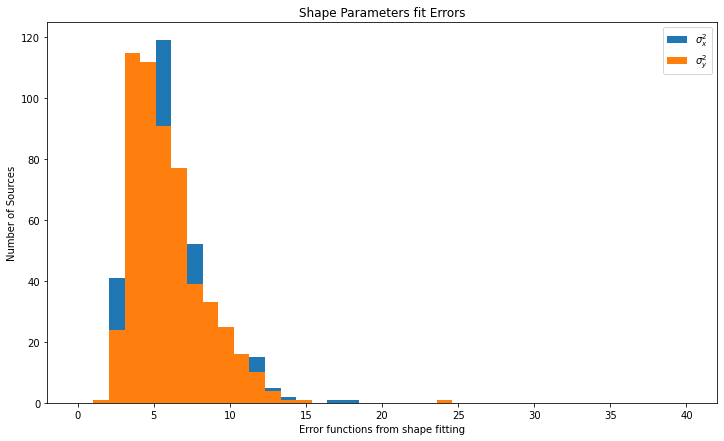

In [23]:
binlist=np.linspace(0,40,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat25snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat25snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [24]:
print('Covar X^2 mean: ', np.mean(mcat25snrcut['covar_sigx2']), '  stdev: ',np.std(mcat25snrcut['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mcat25snrcut['covar_sigy2']), '  stdev: ',np.std(mcat25snrcut['covar_sigy2']))

Covar X^2 mean:  5.813468754558383   stdev:  2.414907826223163
Covar Y^2 mean:  5.917795667568834   stdev:  2.440283187138649


In [25]:
#add quality flags to table
sigXmean=np.mean(mcat25snrcut['covar_sigx2'])
sigXstd=np.std(mcat25snrcut['covar_sigx2'])

sigYmean=np.mean(mcat25snrcut['covar_sigy2'])
sigYstd=np.std(mcat25snrcut['covar_sigy2'])

sigXidx=mcat25snrcut['covar_sigx2']>sigXmean+2*sigXstd
sigYidx=mcat25snrcut['covar_sigy2']>sigYmean+2*sigYstd

mcat25snrcut['shape_qflag'][sigXidx]=mcat25snrcut['shape_qflag'][sigXidx]+1
mcat25snrcut['shape_qflag'][sigYidx]=mcat25snrcut['shape_qflag'][sigYidx]+1

In [26]:
#number of sources that are well fit by shape fitting
np.count_nonzero(mcat25snrcut['shape_qflag']==0)

461

In [27]:
#number of sources that may not be well fit by the shape fitting
np.count_nonzero(mcat25snrcut['shape_qflag']>0)

89

In [28]:
mcat25snrcut

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19,int64,int32,int32
10,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field49,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,1.4264758728342248,-0.020555345248797017 .. 0.0036593754586277446,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.3464-0.0829,0,0,0
10,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field49,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0385800764545763,0.004261958918426649 .. 0.004132877124682528,266.09495036354866,-29.53536811998432,359.34770634158383,-0.08213102280583723,2,"266.09495036354866,-29.53536811998432",SFGC359.3477-0.0821,0,0,0
110,239.5935243132066,159.67910405646535,"266.0976520367033,-29.5169558758474",1.764139043025673,0.0721378574154189,4.206197751772709,0.14435021231467793,5.3089080014104715,0.21659547958952255,842.3886568673647,-0.00014474825239916403,-0.0005061142858704007,0.0050131992536510345,402.0951843261719,401.1825653405876,1.7717599358958247,0.0946964428505747,18.709889015488738,52.649291054210295,4.2366813232533165,0.15607276766213954,27.145551313761057,210.59716421684118,5.377496037241839,0.22507472382367852,23.892047698143664,473.84361948789274,Field49,25,6.634573310297923,6.335492963763728,5.047204487581647,2.399647625406882,1.8519160769371097,35.8905178642937,1.2957647785938915,4.957986624396063,4.229915257742961,0.21253832787472293,-0.00564124632951386 .. 0.00288538569960689,266.0976520367033,-29.5169558758474,359.3646267990569,-0.07449979152752673,6,"266.0976520367033,-29.5169558758474",SFGC359.3646-0.0745,0,0,0
210,202.85403080962172,176.827118767999,"266.1066587461282,-29.5132978707

In [29]:
makeDS9reg('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green');

In [30]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat25snrcut.write('masterCat_25um_Step3.fits',overwrite=True)

## Now for 37 um data

In [31]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#add names to mastercat
mastercat37=createNames(mastercat37)

#print the master catalog
mastercat37

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [31,31]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19
10,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660650792,0.19983777651406937,9.689087998688564,0.38085019356767086,12.619309884034728,0.5084012944385904,947.6871944902596,0.0007800663553625424,0.0018714687757799412,0.012005648033616057,352.5610656738281,343.83677739731905,4.119091807877005,0.21177493264085548,19.450327555350867,99.54006122684149,9.40609045262873,0.3866189968932914,24.329095383858892,362.7865041408023,12.116203135483913,0.5128156222903634,23.6268214321746,644.9537851392042,Field49,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.233883094255242,0.0009533517599529182 .. -0.013928116742721796,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.3482-0.0824
220,204.5406252159332,92.06476523812742,"266.1042949324219,-29.53248553795637",0.035082614020147,0.1863575161942756,0.5641115755791402,0.3557176740627466,1.1732301657180173,0.4741895766568357,947.6871944902596,0.0004165020982478318,0.000848325557958499,0.00899211188559196,368.5865783691406,368.55618739865713,-0.006376030340550126,19.44400810699406,-0.00032791749033763524,99.54006122684149,0.4130102353885003,0.6769058084126266,0.6101443217883256,362.7865041408023,0.9046055609346575,0.5914733046531625,1.5294106324293273,644.9537851392042,Field49,37,6.267103792415868,6.604340732262409,8.691643224960119,4.054137699993753,3.288000121610727,30.373383710272506,1.2330102037854274,14.997895757269042,12.24908153295375,0.2552011597076449,-0.0021126089023682498 .. 0.0006031526414931945,266.1042949324219,-29.53248553795637,359.35441699472284,-0.08755130612233233,2,"266.1042949324219,-29.53248553795637",SFGC359.3544-0.0876
220,122.22624675052246,93.06150156529698,"266.1244774877743,-29.532271586707154",-0.14424832015375122,0.2272009336444123,-0.13643494310760906,0.47799946078541866,0.4910572214753846,0.6628017284959065,947.6871944902596,-0.00020364731991700784,-0.000595345472525497,0.011712948449388715,284.6791082100241,256.24164183897574,-0.1239772534605301,1.3234116649512029,-0.09368003678968737,99.54006122684149,-0.06255444383727421,4.951648490559789,-0.012633054215486602,362.7865041408023,0.6224003312893133,0.9374155165690272,0.6639535193180072,644.9537851392042,Field49,37,5.7272212227913455,5.308667144111945,8.611126548154136,4.129158843509057,3.1136068683563782,32.09720860263171,1.3261657678988779,14.973223370626894,11.771277114978167,1.4200214829440052,-0.04881635518554098 .. -0.009663612274557755,266.1244774877743,-29.532271586707154,359.3637857873563,-0.10240522104702628,3,"266.1244774877743,-29.532271586707154",SFGC359.3638-0.1024
10,232.19490703325073,163.504032152892,"266.09751563203463,-29.517244919747395",4.381759370019283,0.

In [32]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [33]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9reg('mastercatComb_37um_labelID.reg', mastercat37, r, color='yellow', label="id");
makeDS9reg('mastercatComb_37um_label5pixSNR.reg', mastercat37, r, color='cyan', label="aper_snr_5.5pix");

In [34]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat37))

mastercat37=remove_duplicates(mastercat37, 5.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 864
number of likely duplicates:  309
Number of sources with duplicates removed 690


In [35]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [36]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', label="id");

### Quality Flags and Cuts

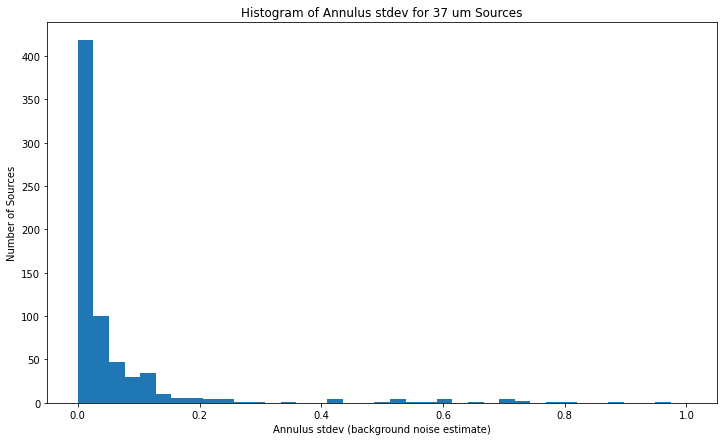

In [37]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 37 um Sources')
plt.hist(mastercat37['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [38]:
#add quality flags for background noise
bkgmean=np.mean(mastercat37['ann_bkg_std'])
bkgstd=np.std(mastercat37['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat37['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat37['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat37['ann_bkg_std']>bkgmean+3*bkgstd


mastercat37['bkg_qflag']=0
mastercat37['bkg_qflag'][bkgstd1sig]=1
mastercat37['bkg_qflag'][bkgstd2sig]=2
mastercat37['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.06459447707500986 , standard deviation of noise measurements:  0.1437511069166995


In [39]:
print('Central distance fit mean: ', np.mean(mastercat37['fit_dist']), '  stdev: ',np.std(mastercat37['fit_dist']))

Central distance fit mean:  1.6913293226972463   stdev:  1.2970831852036326


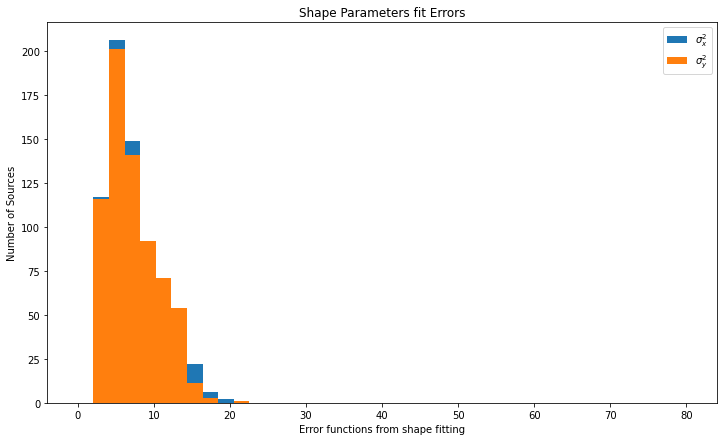

In [40]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat37['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mastercat37['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [41]:
print('Covar X^2 mean: ', np.mean(mastercat37['covar_sigx2']), '  stdev: ',np.std(mastercat37['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mastercat37['covar_sigy2']), '  stdev: ',np.std(mastercat37['covar_sigy2']))

Covar X^2 mean:  7.260536082350182   stdev:  3.4059067716475715
Covar Y^2 mean:  7.304120198686518   stdev:  3.2762520662169115


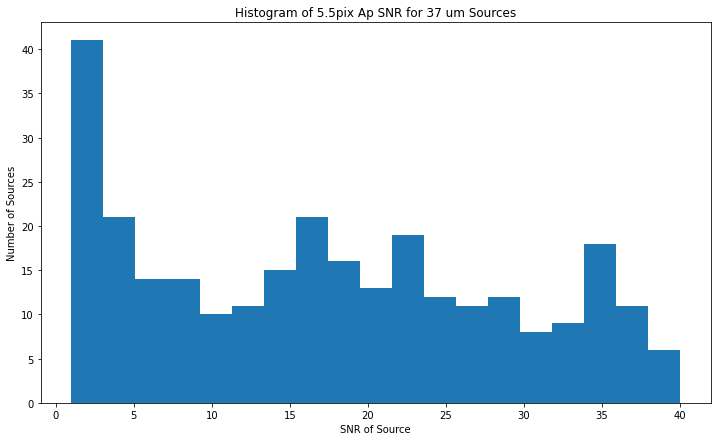

In [42]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 5.5pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_5.5pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [43]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_5.5pix']>=3.0 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  511


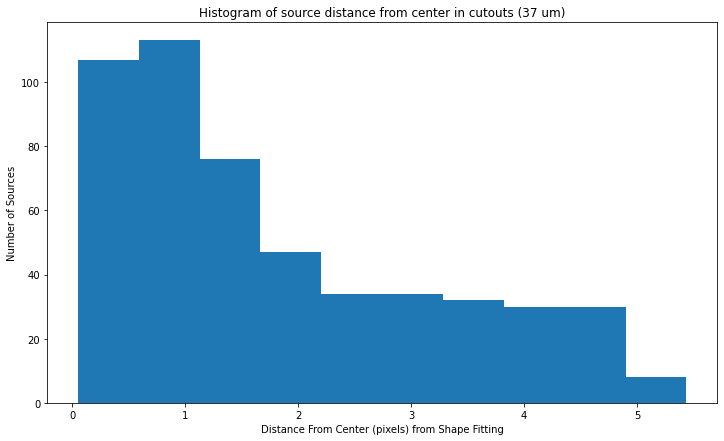

In [44]:
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (37 um)')
plt.hist(mcat37snrcut['fit_dist'])#,bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [45]:
print('Central distance fit mean: ', np.mean(mcat37snrcut['fit_dist']), '  stdev: ',np.std(mcat37snrcut['fit_dist']))

Central distance fit mean:  1.8255979811783711   stdev:  1.3985514549425229


In [46]:
#apply quality flags to table
Distmean=np.mean(mcat37snrcut['fit_dist'])
Diststd=np.std(mcat37snrcut['fit_dist'])

distidx1=mcat37snrcut['fit_dist']>4.0
distidx2=mcat37snrcut['fit_dist']>7.0

mcat37snrcut['shape_qflag']=0

mcat37snrcut['shape_qflag'][distidx1]=10
mcat37snrcut['shape_qflag'][distidx1]=mcat37snrcut['shape_qflag'][distidx1]+10

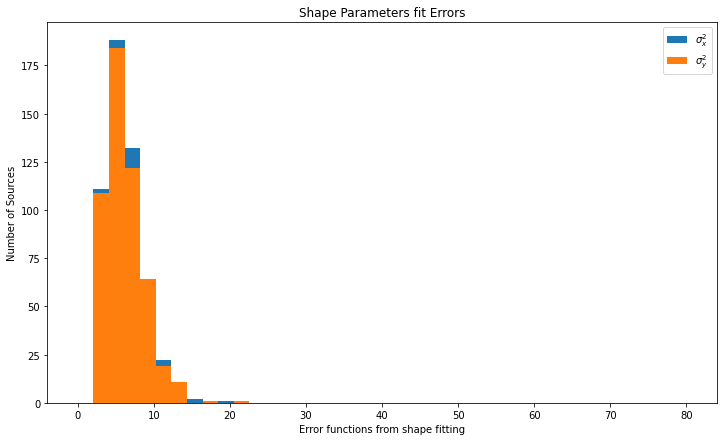

In [47]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat37snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat37snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [48]:
print('Covar X^2 mean: ', np.mean(mcat37snrcut['covar_sigx2']), '  stdev: ',np.std(mcat37snrcut['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mcat37snrcut['covar_sigy2']), '  stdev: ',np.std(mcat37snrcut['covar_sigy2']))

Covar X^2 mean:  6.058742129511313   stdev:  2.4389856849530083
Covar Y^2 mean:  6.166487516386642   stdev:  2.451071440585661


In [49]:
#add quality flags to table
sigXmean=np.mean(mcat37snrcut['covar_sigx2'])
sigXstd=np.std(mcat37snrcut['covar_sigx2'])

sigYmean=np.mean(mcat37snrcut['covar_sigy2'])
sigYstd=np.std(mcat37snrcut['covar_sigy2'])

sigXidx=mcat37snrcut['covar_sigx2']>sigXmean+2*sigXstd
sigYidx=mcat37snrcut['covar_sigy2']>sigYmean+2*sigYstd

mcat37snrcut['shape_qflag'][sigXidx]=mcat37snrcut['shape_qflag'][sigXidx]+1
mcat37snrcut['shape_qflag'][sigYidx]=mcat37snrcut['shape_qflag'][sigYidx]+1

In [50]:
#number of sources that are well fit by shape fitting
np.count_nonzero(mcat37snrcut['shape_qflag']==0)

423

In [51]:
#number of sources that may not be well fit by the shape fitting
np.count_nonzero(mcat37snrcut['shape_qflag']>0)

88

In [52]:
#more cuts to consider?

In [53]:
makeDS9reg('mastercatComb_4pixSNRselect_37m_NoLabel.reg', mcat37snrcut, r, color='green');

In [54]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat37snrcut.write('masterCat_37um_Step3.fits',overwrite=True)

## Crossmatch the 25 and 37 um catalogs

In [55]:
#get source coordinates from both tables
sources25=mcat25snrcut['sky_centroid']
sources37=mcat37snrcut['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 5*u.arcsec) #use larger search radius?
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  351


In [56]:
matched25=mcat25snrcut[rdx]
matched37=mcat37snrcut[idx]

In [57]:
notrdx=findNOTindex(mcat25snrcut,rdx)
only25=mcat25snrcut[notrdx]

notidx=findNOTindex(mcat37snrcut,idx)
only37=mcat37snrcut[notidx]

In [58]:
#write out catalogs?
#matched25.write('masterCat_step3_25matched.fits',overwrite=True)
#matched37.write('masterCat_step3_37matched.fits',overwrite=True)
#only25.write('masterCat_step3_25only.fits',overwrite=True)
#only37.write('masterCat_step3_37only.fits',overwrite=True)

## Do fixed aperture photometry for non-detections

In [59]:
#run forced photometry at 37 um
wavelength=37

for info in field._registry:
    filename=info.file37
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    m3lims=info.m3lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    #create pixel error map by taking sqrt of variance map
    errormap=np.sqrt(varmap)
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [5.5, 10.5, 14] #aperture radii to use in photoemtry - units are pixels
    r_in = 14  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 22  #outer radius for background annulus - units are pixels #20 or 25
    
    
    
    tab=only25[only25['Field']==name]
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table
        mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False,cutsize=31) #optional plot=True for diagnostic plots
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)
        
    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field49



Script running on field:  Field48



Script running on field:  Field45



Script running on field:  Field43



Script running on field:  Field11



Script running on field:  Field10



Script running on field:  Field04



Script running on field:  Field03



Script running on field:  Field02



Script running on field:  Field01



Script running on field:  Field05


WARNING


Script running on field:  Field06


: Input data contains invalid values (NaNs or infs), which were automatically masked. [photutils.background.background_2d]



Script running on field:  Field42



Script running on field:  Field39



Script running on field:  Field41



Script running on field:  Field40



Script running on field:  Field38



Script running on field:  Field37



Script running on field:  Field33



Script running on field:  Field34



Script running on field:  Field32



Script running on field:  Field31



Script running on field:  Field29



Script running on field:  Field28



Script running on field:  Field25



Script running on field:  Field24



Script running on field:  Field20



Script running on field:  Field15



Script running on field:  Field17



Script running on field:  Field13



Script running on field:  Field12



Script running on field:  Field14



Script running on field:  Field16
No sources found in Combined Source List

Script running on field:  Field21



Script running on field:  Field18



Script running on field:  Field30



Script running on field:  Field36



Script running on field:  Field23



Script running on field:  Field19



Script running on field:  Field22



Script running on field:  Field26



Script running on field:  Field27



Script running on field:  Field07
No sources found in Combined Source List

Script running on field:  Field08


No sources found in Combined Source List

Script running on field:  Field09



Script running on field:  Field35
No sources found in Combined Source List

Script running on field:  Field44


No sources found in Combined Source List

Script running on field:  Field46



Script running on field:  Field47
No sources found in Combined Source List


In [60]:
#combine different out files
Cat37Force=CombineFieldResults('Forced',wavelength)

len(Cat37Force)

219

In [61]:
#get source coordinates from 'finders' and SEG
OGsources=only25['sky_centroid']
FCsources=Cat37Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  214


In [62]:
matchOG25=only25[rdx]
matchFC37=Cat37Force[idx]

In [63]:
#run forced photometry at 25 um
wavelength=25

for info in field._registry:
    filename=info.file25
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    m3lims=info.m3lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    #create pixel error map by taking sqrt of variance map
    errormap=np.sqrt(varmap)
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [4, 8, 12] #aperture radii to use in photoemtry - units are pixels
    r_in = 12  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 20  #outer radius for background annulus - units are pixels #20 or 25
    
    tab=only37[only37['Field']==name]
    
    #print(len(tab))
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table
        mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False) #optional plot=True for diagnostic plots
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)

    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field49



Script running on field:  Field48



Script running on field:  Field45



Script running on field:  Field43



Script running on field:  Field11


WARNING


Script running on field:  Field10


: Input data contains invalid values (NaNs or infs), which were automatically masked. [photutils.background.background_2d]


No sources found in Combined Source List

Script running on field:  Field04



Script running on field:  Field03



Script running on field:  Field02



Script running on field:  Field01



Script running on field:  Field05



Script running on field:  Field06



Script running on field:  Field42



Script running on field:  Field39



Script running on field:  Field41



Script running on field:  Field40



Script running on field:  Field38



Script running on field:  Field37



Script running on field:  Field33



Script running on field:  Field34



Script running on field:  Field32



Script running on field:  Field31



Script running on field:  Field29



Script running on field:  Field28
No sources found in Combined Source List

Script running on field:  Field25



Script running on field:  Field24
No sources found in Combined Source List

Script running on field:  Field20



Script running on field:  Field15



Script running on field:  Field17



Script running on field:  Field13



Script running on field:  Field12
No sources found in Combined Source List

Script running on field:  Field14



Script running on field:  Field16



Script running on field:  Field21



Script running on field:  Field18



Script running on field:  Field30



Script running on field:  Field36



Script running on field:  Field23



Script running on field:  Field19



Script running on field:  Field22


No sources found in Combined Source List

Script running on field:  Field26



Script running on field:  Field27



Script running on field:  Field07



Script running on field:  Field08
No sources found in Combined Source List

Script running on field:  Field09



Script running on field:  Field35



Script running on field:  Field44
No sources found in Combined Source List

Script running on field:  Field46


No sources found in Combined Source List

Script running on field:  Field47


In [64]:
#combine different out files
Cat25Force=CombineFieldResults('Forced',wavelength)

len(Cat25Force)

183

In [65]:
#get source coordinates from 'finders' and SEG
OGsources=only37['sky_centroid']
FCsources=Cat25Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  178


In [66]:
matchOG37=only37[rdx]
matchFC25=Cat25Force[idx]

## Build master catalog from other tables

In [67]:
t1=Table()
t1['SourceID']=matched25['SourceID']
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um_Flux']=matched25['aper_sum_bkgsub_8pix']
t1['25um_Flux_err']=matched25['aper_8pix_noise']
t1['25um_SNR']=matched25['aper_snr_8pix']
t1['25ApRatio8_4']=matched25['aper_sum_bkgsub_8pix']/matched25['aper_sum_bkgsub_4pix']
t1['25ApRatio8_12']=matched25['aper_sum_bkgsub_8pix']/matched25['aper_sum_bkgsub_12pix']
t1['fwhm25']=matched25['fwhm']
t1['elong25']=matched25['elongation']
t1['bkg_qflag25']=matched25['bkg_qflag']
t1['shape_qflag25']=matched25['shape_qflag']
t1['cutout25']=matched25['cutouts']
t1['37um_Flux']=matched37['aper_sum_bkgsub_10.5pix']
t1['37um_Flux_err']=matched37['aper_10.5pix_noise']
t1['37um_SNR']=matched37['aper_snr_10.5pix']
t1['37ApRatio10.5_5.5']=matched37['aper_sum_bkgsub_10.5pix']/matched37['aper_sum_bkgsub_5.5pix']
t1['37ApRatio14_10.5']=matched37['aper_sum_bkgsub_14pix']/matched37['aper_sum_bkgsub_10.5pix']
t1['fwhm37']=matched37['fwhm']
t1['elong37']=matched37['elongation']
t1['bkg_qflag37']=matched37['bkg_qflag']
t1['shape_qflag37']=matched37['shape_qflag']
t1['cutout37']=matched37['cutouts']
t1['sky_centroid']=matched25['sky_centroid']


t2=Table()
t2['SourceID']=matchOG25['SourceID']
t2['RA(J2000)']=matchOG25['RA(J2000)']
t2['DEC(J2000)']=matchOG25['DEC(J2000)']
t2['25um_Flux']=matchOG25['aper_sum_bkgsub_8pix']
t2['25um_Flux_err']=matchOG25['aper_8pix_noise']
t2['25um_SNR']=matchOG25['aper_snr_8pix']
t2['25ApRatio8_4']=matchOG25['aper_sum_bkgsub_8pix']/matchOG25['aper_sum_bkgsub_4pix']
t2['25ApRatio8_12']=matchOG25['aper_sum_bkgsub_8pix']/matchOG25['aper_sum_bkgsub_12pix']
t2['fwhm25']=matchOG25['fwhm']
t2['elong25']=matchOG25['elongation']
t2['bkg_qflag25']=matchOG25['bkg_qflag']
t2['shape_qflag25']=matchOG25['shape_qflag']
t2['cutout25']=matchOG25['cutouts']
t2['37um_Flux']=matchFC37['aper_sum_bkgsub_10.5pix']
t2['37um_Flux_err']=matchFC37['aper_10.5pix_noise']
t2['37um_SNR']=matchFC37['aper_snr_10.5pix']
t2['37ApRatio10.5_5.5']=matchFC37['aper_sum_bkgsub_10.5pix']/matchFC37['aper_sum_bkgsub_5.5pix']
t2['37ApRatio14_10.5']=matchFC37['aper_sum_bkgsub_14pix']/matchFC37['aper_sum_bkgsub_10.5pix']
t2['fwhm37']=matchFC37['fwhm']
t2['elong37']=matchFC37['elongation']
#t2['bkg_qflag37']=matchFC37['bkg_qflag']
#t2['shape_qflag37']=matchFC37['shape_qflag']
#t2['cutout37']=matchFC37['cutouts']
t2['sky_centroid']=matchOG25['sky_centroid']


t3=Table()
t3['SourceID']=matchOG37['SourceID']
t3['RA(J2000)']=matchOG37['RA(J2000)']
t3['DEC(J2000)']=matchOG37['DEC(J2000)']
t3['25um_Flux']=matchFC25['aper_sum_bkgsub_8pix']
t3['25um_Flux_err']=matchFC25['aper_8pix_noise']
t3['25um_SNR']=matchFC25['aper_snr_8pix']
t3['25ApRatio8_4']=matchFC25['aper_sum_bkgsub_8pix']/matchFC25['aper_sum_bkgsub_4pix']
t3['25ApRatio8_12']=matchFC25['aper_sum_bkgsub_8pix']/matchFC25['aper_sum_bkgsub_12pix']
t3['fwhm25']=matchFC25['fwhm']
t3['elong25']=matchFC25['elongation']
#t3['bkg_qflag25']=matchFC25['bkg_qflag']
#t3['shape_qflag25']=matchFC25['shape_qflag']
#t3['cutout25']=matchFC25['cutouts']
t3['37um_Flux']=matchOG37['aper_sum_bkgsub_10.5pix']
t3['37um_Flux_err']=matchOG37['aper_10.5pix_noise']
t3['37um_SNR']=matchOG37['aper_snr_10.5pix']
t3['37ApRatio10.5_5.5']=matchOG37['aper_sum_bkgsub_10.5pix']/matchOG37['aper_sum_bkgsub_5.5pix']
t3['37ApRatio14_10.5']=matchOG37['aper_sum_bkgsub_14pix']/matchOG37['aper_sum_bkgsub_10.5pix']
t3['fwhm37']=matchOG37['fwhm']
t3['elong37']=matchOG37['elongation']
t3['bkg_qflag37']=matchOG37['bkg_qflag']
t3['shape_qflag37']=matchOG37['shape_qflag']
t3['cutout37']=matchOG37['cutouts']
t3['sky_centroid']=matchOG37['sky_centroid']

In [68]:
mastercat=vstack((t1,t2,t3))

In [69]:
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux,25um_Flux_err,25um_SNR,25ApRatio8_4,25ApRatio8_12,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux,37um_Flux_err,37um_SNR,37ApRatio10.5_5.5,37ApRatio14_10.5,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid
,deg,deg,,,,,,pix,,,,,,,,,,pix,,,,,"deg,deg"
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,object
SFGC359.3477-0.0821,266.09495036354866,-29.53536811998432,4.543281003613607,0.1906223032330868,23.83394244302163,2.4278914670023948,0.7126387339245635,5.978782385990122,1.3346648239578836,0,0,0.004261958918426649 .. 0.004132877124682528,9.40609045262873,0.3866189968932914,24.329095383858892,2.2835350342619973,1.288123178966218,5.8605408503544005,1.2553991311193977,0,0,0.0009533517599529182 .. -0.013928116742721796,"266.09495036354866,-29.53536811998432"
SFGC359.3646-0.0745,266.0976520367033,-29.5169558758474,4.2366813232533165,0.15607276766213954,27.145551313761057,2.391227636102515,0.7878539182385608,5.047204487581647,1.2957647785938915,0,0,-0.00564124632951386 .. 0.00288538569960689,8.482491933965402,0.37438775433980914,22.65696950725145,1.945564102522209,1.0604311532026942,6.016967157926574,1.5484343338450575,0,0,-0.005425191055959143 .. 0.007362955799645543,"266.0976520367033,-29.5169558758474"
SFGC359.3718-0.0793,266.1066587461282,-29.513297870753597,9.07803779866726,0.152329644132367,59.594689204281806,2.521061000058074,0.7053791195208994,5.749775656043468,2.1520466486018877,0,0,-0.004857572897508759 .. -0.001478254077002146,16.203395620298007,0.3728271088848336,43.46088370227188,2.2669450056652187,1.236140908310659,5.924723139403877,1.772227052203805,0,0,-0.0012886782649523948 .. -0.0030301990446908525,"266.1066587461282,-29.513297870753597"
SFGC359.3744-0.0883,266.11699223318425,-29.51585973844053,5.282509741038088,0.15519896316540904,34.037016957439704,2.8269448152172365,0.6781344121305577,5.7112215165549705,1.671489378478552,0,0,0.0025294988124029876 .. -0.004252675530716267,13.12507171009999,0.37130481608977406,35.34850920685772,2.1761494931294534,1.2208578957289915,5.865876407779754,1.5422310390614253,0,0,0.013876590368192571 .. -0.026311473971190782,"266.11699223318425,-29.51585973844053"
SFGC359.3757-0.0937,266.12312364597364,-29.517588948087333,4.445749620273259,0.15813816601779757,28.11307182968667,2.7463997154402406,0.6682135930516415,6.238228318383685,1.7394550188998046,0,0,0.0005505248608640297 .. 0.004378246095691245,10.496743435067758,0.36870743637160597,28.46903099748847,2.2921917193116492,1.2419456115939553,6.5990222017718745,2.1355569161642074,0,1,-0.005111354997162854 .. -0.0007443572321900738,"266.12312364597364,-29.517588948087333"
SFGC359.4035+0.0012,266.04694161813114,-29.444187095468855,5.0101016333100405,1.7860752039904493,2.8050899660420074,1.7634925518905828,0.8407742006232168,4.643748538630767,1.1541440867831758,0,0,0.002236249382914649 .. 0.0022268410735802116,13.811278911690247,3.2055657407589333,4.308530858088207,1.672324210883401,1.0844361260554038,4.686459265492605,1.2740279643602426,0,0,0.006501735743264715 .. -0.0004414936915823394,"266.04694161813114,-29.444187095468855"
SFGC359.4097+0.0325,266.02006908793686,-29.42252156100146,6.284756369994705,1.4794647297790249,4.247993374558788,2.5814680011894047,0.6692555271886628,5.239211671774341,1.1013696340193468,0,0,-0.0038546954309478672 .. 0.0012057306933886823,16.92134261596903,2.902060935193106,5.830801969305675,2.7174668762223697,1.393556228046671,6.028401533143166,1.1441339625558171,0,0,0.021827378396865924 .. -0.008483021045970107,"266.02006908793686,-29.42252156100146"
SFGC359.4097+0.0325,266.02006908793686,-29.42252156100146,6.284756369994705,1.4794647297790249,4.247993374558788,2.5814680011894047,0.6692555271886628,5.239211671774341,1.1013696340193468,0,0,-0.0038546954309478672 .. 0.0012057306933886823,12.281443415408363,2.77

In [70]:
#change format of columns to save fewer decimal places

if 'sky_centroid' in mastercat.columns:
    skycoords=mastercat['sky_centroid']
    mastercat.remove_columns('sky_centroid')
    

for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type' and col!='SourceID': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

        
if 'sky_centroid' not in mastercat.columns:
    mastercat['sky_centroid']=skycoords
        
        
#display catalog
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux,25um_Flux_err,25um_SNR,25ApRatio8_4,25ApRatio8_12,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux,37um_Flux_err,37um_SNR,37ApRatio10.5_5.5,37ApRatio14_10.5,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid
,deg,deg,,,,,,pix,,,,,,,,,,pix,,,,,"deg,deg"
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,object
SFGC359.3477-0.0821,266.09495036354866,-29.53536811998432,4.543,0.1906,23.83,2.428,0.7126,5.979,1.335,0,0,0.004262 .. 0.004133,9.406,0.3866,24.33,2.284,1.288,5.861,1.255,0,0,0.0009534 .. -0.01393,"266.09495036354866,-29.53536811998432"
SFGC359.3646-0.0745,266.0976520367033,-29.5169558758474,4.237,0.1561,27.15,2.391,0.7879,5.047,1.296,0,0,-0.005641 .. 0.002885,8.482,0.3744,22.66,1.946,1.06,6.017,1.548,0,0,-0.005425 .. 0.007363,"266.0976520367033,-29.5169558758474"
SFGC359.3718-0.0793,266.1066587461282,-29.513297870753597,9.078,0.1523,59.59,2.521,0.7054,5.75,2.152,0,0,-0.004858 .. -0.001478,16.2,0.3728,43.46,2.267,1.236,5.925,1.772,0,0,-0.001289 .. -0.00303,"266.1066587461282,-29.513297870753597"
SFGC359.3744-0.0883,266.11699223318425,-29.51585973844053,5.283,0.1552,34.04,2.827,0.6781,5.711,1.671,0,0,0.002529 .. -0.004253,13.13,0.3713,35.35,2.176,1.221,5.866,1.542,0,0,0.01388 .. -0.02631,"266.11699223318425,-29.51585973844053"
SFGC359.3757-0.0937,266.12312364597364,-29.517588948087333,4.446,0.1581,28.11,2.746,0.6682,6.238,1.739,0,0,0.0005505 .. 0.004378,10.5,0.3687,28.47,2.292,1.242,6.599,2.136,0,1,-0.005111 .. -0.0007444,"266.12312364597364,-29.517588948087333"
SFGC359.4035+0.0012,266.04694161813114,-29.444187095468855,5.01,1.786,2.805,1.763,0.8408,4.644,1.154,0,0,0.002236 .. 0.002227,13.81,3.206,4.309,1.672,1.084,4.686,1.274,0,0,0.006502 .. -0.0004415,"266.04694161813114,-29.444187095468855"
SFGC359.4097+0.0325,266.02006908793686,-29.42252156100146,6.285,1.479,4.248,2.581,0.6693,5.239,1.101,0,0,-0.003855 .. 0.001206,16.92,2.902,5.831,2.717,1.394,6.028,1.144,0,0,0.02183 .. -0.008483,"266.02006908793686,-29.42252156100146"
SFGC359.4097+0.0325,266.02006908793686,-29.42252156100146,6.285,1.479,4.248,2.581,0.6693,5.239,1.101,0,0,-0.003855 .. 0.001206,12.28,2.77,4.433,2.794,1.393,6.158,1.867,0,0,0.0115 .. 0.01695,"266.02006908793686,-29.42252156100146"


In [71]:
#upper limit criteria

crit1=mastercat['25um_SNR']<3.0
crit2=mastercat['37um_SNR']<3.0

In [72]:
mastercat['25um_Flux'][crit1]=mastercat['25um_Flux_err'][crit1]*3+mastercat['25um_Flux'][crit1]
mastercat['37um_Flux'][crit2]=mastercat['37um_Flux_err'][crit2]*3+mastercat['37um_Flux'][crit2]

In [73]:
mastercat['25um_SNR'][crit1]=-1
mastercat['37um_SNR'][crit2]=-1

mastercat['fwhm25'][crit1]=-1
mastercat['fwhm37'][crit2]=-1

mastercat['elong25'][crit1]=-1
mastercat['elong37'][crit2]=-1

mastercat['shape_qflag25'][crit1]=100
mastercat['shape_qflag37'][crit2]=100

In [74]:
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux,25um_Flux_err,25um_SNR,25ApRatio8_4,25ApRatio8_12,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux,37um_Flux_err,37um_SNR,37ApRatio10.5_5.5,37ApRatio14_10.5,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid
,deg,deg,,,,,,pix,,,,,,,,,,pix,,,,,"deg,deg"
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,object
SFGC359.3477-0.0821,266.09495036354866,-29.53536811998432,4.543,0.1906,23.83,2.428,0.7126,5.979,1.335,0,0,0.004262 .. 0.004133,9.406,0.3866,24.33,2.284,1.288,5.861,1.255,0,0,0.0009534 .. -0.01393,"266.09495036354866,-29.53536811998432"
SFGC359.3646-0.0745,266.0976520367033,-29.5169558758474,4.237,0.1561,27.15,2.391,0.7879,5.047,1.296,0,0,-0.005641 .. 0.002885,8.482,0.3744,22.66,1.946,1.06,6.017,1.548,0,0,-0.005425 .. 0.007363,"266.0976520367033,-29.5169558758474"
SFGC359.3718-0.0793,266.1066587461282,-29.513297870753597,9.078,0.1523,59.59,2.521,0.7054,5.75,2.152,0,0,-0.004858 .. -0.001478,16.2,0.3728,43.46,2.267,1.236,5.925,1.772,0,0,-0.001289 .. -0.00303,"266.1066587461282,-29.513297870753597"
SFGC359.3744-0.0883,266.11699223318425,-29.51585973844053,5.283,0.1552,34.04,2.827,0.6781,5.711,1.671,0,0,0.002529 .. -0.004253,13.13,0.3713,35.35,2.176,1.221,5.866,1.542,0,0,0.01388 .. -0.02631,"266.11699223318425,-29.51585973844053"
SFGC359.3757-0.0937,266.12312364597364,-29.517588948087333,4.446,0.1581,28.11,2.746,0.6682,6.238,1.739,0,0,0.0005505 .. 0.004378,10.5,0.3687,28.47,2.292,1.242,6.599,2.136,0,1,-0.005111 .. -0.0007444,"266.12312364597364,-29.517588948087333"
SFGC359.4035+0.0012,266.04694161813114,-29.444187095468855,10.37,1.786,-1,1.763,0.8408,-1,-1,0,100,0.002236 .. 0.002227,13.81,3.206,4.309,1.672,1.084,4.686,1.274,0,0,0.006502 .. -0.0004415,"266.04694161813114,-29.444187095468855"
SFGC359.4097+0.0325,266.02006908793686,-29.42252156100146,6.285,1.479,4.248,2.581,0.6693,5.239,1.101,0,0,-0.003855 .. 0.001206,16.92,2.902,5.831,2.717,1.394,6.028,1.144,0,0,0.02183 .. -0.008483,"266.02006908793686,-29.42252156100146"
SFGC359.4097+0.0325,266.02006908793686,-29.42252156100146,6.285,1.479,4.248,2.581,0.6693,5.239,1.101,0,0,-0.003855 .. 0.001206,12.28,2.77,4.433,2.794,1.393,6.158,1.867,0,0,0.0115 .. 0.01695,"266.02006908793686,-29.42252156100146"


In [75]:
#checks on table quantities

In [76]:
#mastercat['25um_Flux']>0

In [77]:
#write out final catalog
mastercat.write('masterCat_step3_combined.fits',overwrite=True)

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [ ]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

In [ ]:
Segcat25snr

In [ ]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

In [ ]:
Segcat37snr

## testing...

In [ ]:
np.max(Segcat25['fwhm'])

In [ ]:
np.min(Segcat25['fwhm'])

In [ ]:
np.mean(Segcat25['fwhm'])

In [ ]:
np.std(Segcat25['fwhm'])

In [ ]:
np.mean(Segcat25['fwhm_seg'])

In [ ]:
np.std(Segcat25['fwhm_seg'])

In [ ]:
#now lets look at SNR distrobution
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for Seg sources at 25um')
plt.hist(Segcat25['fwhm'],bins=binlist,label='ShapePar')
plt.hist(Segcat25['fwhm_seg'],bins=binlist,label='Segment')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [ ]:
xmatch=mcat25snrcut['type']=='C'
segonly=mcat25snrcut['type']=='S'
daoonly=mcat25snrcut['type']=='D'

In [ ]:
xmatch25=mcat25snrcut[xmatch]
seg25=mcat25snrcut[segonly]
dao25=mcat25snrcut[daoonly]

In [ ]:
#now lets look at SNR distrobution
binlist=np.linspace(1,8,25)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for all sources at 25um')
plt.hist(seg25['fwhm'],bins=binlist,label='Seg')
plt.hist(dao25['fwhm'],bins=binlist,label='dao')
plt.hist(xmatch25['fwhm'],bins=binlist,label='both')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()